In [1]:
import os
import sys
import pandas as pd
import numpy as np
from pandas import Series, DataFrame

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
pd.set_option('display.max_columns', 500) 
pd.set_option('display.max_rows', 500) 

In [4]:
# pip install lightgbm --install-option=--gpu


# 前処理

In [5]:
status = pd.read_csv('status.csv') 
status["date"] = pd.to_datetime(status[["year", "month", "day"]])

station = pd.read_csv("station.csv")
station = station.drop(["installation_date",], axis=1)

weather = pd.read_csv('weather.csv') 
weather['date'] = pd.to_datetime(weather['date'],format="%Y-%m-%d")
weather = weather.drop(["events",                                     
#                         "max_temperature","min_temperature","mean_temperature",
#                         "max_dew_point","min_dew_point","mean_dew_point",
#                         "max_humidity","min_humidity","mean_humidity",
#                         "max_sea_level_pressure","mean_sea_level_pressure","min_sea_level_pressure",
#                         "max_visibility","min_visibility",
#                         "max_wind_Speed","cloud_cover","wind_dir_degrees",                                            
#                         "mean_visibility",
#                         "mean_wind_speed",                       
#                         "precipitation",                        
                       ], axis=1)

In [6]:
#曜日を追加する
def get_week(dt):
    w_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    return(w_list[dt.weekday()])
status["weekday"] = status["date"].apply(get_week)

status.head(2)

,id,year,month,day,hour,station_id,bikes_available,predict,date,weekday
0,0,2013,9,1,0,0,11.0,0,2013-09-01,Sunday
1,1,2013,9,1,1,0,11.0,0,2013-09-01,Sunday


In [7]:
station.head(2)

,station_id,lat,long,dock_count,city
0,0,37.32973,-121.90178,27,city1
1,1,37.33070,-121.88898,15,city1


In [8]:
weather.head(2)

,date,max_temperature,mean_temperature,min_temperature,max_dew_point,mean_dew_point,min_dew_point,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure,mean_sea_level_pressure,min_sea_level_pressure,max_visibility,mean_visibility,min_visibility,max_wind_Speed,mean_wind_speed,precipitation,cloud_cover,wind_dir_degrees
0,2013-09-01,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.0,1,354
1,2013-09-02,80,71,66,64,61,58,80,70,58,29.95,29.95,29.86,10,10,10,14,4,0.0,5,337


In [9]:
#"date"でstatus,station,weatherをmergeする
_ = pd.merge(status, station, on = "station_id")
_ = pd.merge(_, weather, on = "date")

In [10]:
_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1226400 entries, 0 to 1226399
Data columns (total 34 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   id                       1226400 non-null  int64         
 1   year                     1226400 non-null  int64         
 2   month                    1226400 non-null  int64         
 3   day                      1226400 non-null  int64         
 4   hour                     1226400 non-null  int64         
 5   station_id               1226400 non-null  int64         
 6   bikes_available          809995 non-null   float64       
 7   predict                  1226400 non-null  int64         
 8   date                     1226400 non-null  datetime64[ns]
 9   weekday                  1226400 non-null  object        
 10  lat                      1226400 non-null  float64       
 11  long                     1226400 non-null  float64       
 12  

In [11]:
_.head(2)

,id,year,month,day,hour,station_id,bikes_available,predict,date,weekday,lat,long,dock_count,city,max_temperature,mean_temperature,min_temperature,max_dew_point,mean_dew_point,min_dew_point,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure,mean_sea_level_pressure,min_sea_level_pressure,max_visibility,mean_visibility,min_visibility,max_wind_Speed,mean_wind_speed,precipitation,cloud_cover,wind_dir_degrees
0,0,2013,9,1,0,0,11.0,0,2013-09-01,Sunday,37.32973,-121.90178,27,city1,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.0,1,354
1,1,2013,9,1,1,0,11.0,0,2013-09-01,Sunday,37.32973,-121.90178,27,city1,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.0,1,354


In [12]:
_.shape

(1226400, 34)

In [13]:
#"city"と"weekday"をone-hot化
_ = pd.get_dummies(_, dummy_na=False) 

In [14]:
_.head(2)

,id,year,month,day,hour,station_id,bikes_available,predict,date,lat,long,dock_count,max_temperature,mean_temperature,min_temperature,max_dew_point,mean_dew_point,min_dew_point,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure,mean_sea_level_pressure,min_sea_level_pressure,max_visibility,mean_visibility,min_visibility,max_wind_Speed,mean_wind_speed,precipitation,cloud_cover,wind_dir_degrees,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,city_city1,city_city2,city_city3,city_city4,city_city5
0,0,2013,9,1,0,0,11.0,0,2013-09-01,37.32973,-121.90178,27,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.0,1,354,0,0,0,1,0,0,0,1,0,0,0,0
1,1,2013,9,1,1,0,11.0,0,2013-09-01,37.32973,-121.90178,27,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.0,1,354,0,0,0,1,0,0,0,1,0,0,0,0


In [15]:
# "train"と"test"を区分
train = _.loc[_["predict"] == 0]
test = _.loc[_["predict"] == 1]

In [16]:
train.shape

(1033200, 44)

In [17]:
train.head(2)

,id,year,month,day,hour,station_id,bikes_available,predict,date,lat,long,dock_count,max_temperature,mean_temperature,min_temperature,max_dew_point,mean_dew_point,min_dew_point,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure,mean_sea_level_pressure,min_sea_level_pressure,max_visibility,mean_visibility,min_visibility,max_wind_Speed,mean_wind_speed,precipitation,cloud_cover,wind_dir_degrees,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,city_city1,city_city2,city_city3,city_city4,city_city5
0,0,2013,9,1,0,0,11.0,0,2013-09-01,37.32973,-121.90178,27,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.0,1,354,0,0,0,1,0,0,0,1,0,0,0,0
1,1,2013,9,1,1,0,11.0,0,2013-09-01,37.32973,-121.90178,27,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.0,1,354,0,0,0,1,0,0,0,1,0,0,0,0


In [18]:
train.isna().any(axis=0)

id                         False
year                       False
month                      False
day                        False
hour                       False
station_id                 False
bikes_available             True
predict                    False
date                       False
lat                        False
long                       False
dock_count                 False
max_temperature            False
mean_temperature           False
min_temperature            False
max_dew_point              False
mean_dew_point             False
min_dew_point              False
max_humidity               False
mean_humidity              False
min_humidity               False
max_sea_level_pressure     False
mean_sea_level_pressure    False
min_sea_level_pressure     False
max_visibility             False
mean_visibility            False
min_visibility             False
max_wind_Speed             False
mean_wind_speed            False
precipitation              False
cloud_cove

In [19]:
test.isna().any(axis=0)

id                         False
year                       False
month                      False
day                        False
hour                       False
station_id                 False
bikes_available             True
predict                    False
date                       False
lat                        False
long                       False
dock_count                 False
max_temperature            False
mean_temperature           False
min_temperature            False
max_dew_point              False
mean_dew_point             False
min_dew_point              False
max_humidity               False
mean_humidity              False
min_humidity               False
max_sea_level_pressure     False
mean_sea_level_pressure    False
min_sea_level_pressure     False
max_visibility             False
mean_visibility            False
min_visibility             False
max_wind_Speed             False
mean_wind_speed            False
precipitation              False
cloud_cove

In [20]:
#trainの欠損値を削除
train = train.dropna(subset = ["bikes_available"])
train.shape

(809995, 44)

In [21]:
#"yearmonth"を追加する
def add_yearmonth(df):
    df1 = df[df['month'] < 10].copy()
    df2 = df[df['month'] >= 10].copy()
    df1['yearmonth'] = df1['year'].astype(str) + ('0' + df1['month'].astype(str))
    df2['yearmonth'] = df2['year'].astype(str) + df2['month'].astype(str)
    return pd.concat([df1, df2])

train = add_yearmonth(train)
test = add_yearmonth(test)

In [22]:
train.head(2)

,id,year,month,day,hour,station_id,bikes_available,predict,date,lat,long,dock_count,max_temperature,mean_temperature,min_temperature,max_dew_point,mean_dew_point,min_dew_point,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure,mean_sea_level_pressure,min_sea_level_pressure,max_visibility,mean_visibility,min_visibility,max_wind_Speed,mean_wind_speed,precipitation,cloud_cover,wind_dir_degrees,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,city_city1,city_city2,city_city3,city_city4,city_city5,yearmonth
0,0,2013,9,1,0,0,11.0,0,2013-09-01,37.32973,-121.90178,27,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.0,1,354,0,0,0,1,0,0,0,1,0,0,0,0,201309
1,1,2013,9,1,1,0,11.0,0,2013-09-01,37.32973,-121.90178,27,81,70,61,62,58,54,80,67,47,29.94,29.95,29.85,10,10,10,14,4,0.0,1,354,0,0,0,1,0,0,0,1,0,0,0,0,201309


In [23]:
test.head(2)

,id,year,month,day,hour,station_id,bikes_available,predict,date,lat,long,dock_count,max_temperature,mean_temperature,min_temperature,max_dew_point,mean_dew_point,min_dew_point,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure,mean_sea_level_pressure,min_sea_level_pressure,max_visibility,mean_visibility,min_visibility,max_wind_Speed,mean_wind_speed,precipitation,cloud_cover,wind_dir_degrees,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,city_city1,city_city2,city_city3,city_city4,city_city5,yearmonth
613201,8761,2014,9,1,1,0,NaN,1,2014-09-01,37.32973,-121.90178,27,85,73,60,60,58,53,84,59,34,29.87,29.83,29.77,10,10,10,17,5,0.0,0,342,0,1,0,0,0,0,0,1,0,0,0,0,201409
613202,8762,2014,9,1,2,0,NaN,1,2014-09-01,37.32973,-121.90178,27,85,73,60,60,58,53,84,59,34,29.87,29.83,29.77,10,10,10,17,5,0.0,0,342,0,1,0,0,0,0,0,1,0,0,0,0,201409


In [24]:
#年月をチェックする
def check_yearmonth(df):
    groupby = df.groupby("yearmonth").apply(lambda x: len(x)).reset_index()
    groupby.columns = ["yearmonth","size"]
    groupby = groupby.sort_values("yearmonth", ascending = True)
    print("size_sum: " + str(groupby["size"].sum()) )
    return groupby

check_yearmonth(train)

size_sum: 809995


,yearmonth,size
0,201309,46080
1,201310,47616
2,201311,46080
3,201312,47664
4,201401,50083
5,201402,45900
6,201403,51336
7,201404,50196
8,201405,52080
9,201406,50400


In [25]:
check_yearmonth(test)

size_sum: 193200


,yearmonth,size
0,201409,16100
1,201410,16100
2,201411,16100
3,201412,16100
4,201501,16100
5,201502,16100
6,201503,16100
7,201504,16100
8,201505,16100
9,201506,16100


size_sum: 809995
size_sum: 193200


<AxesSubplot:>

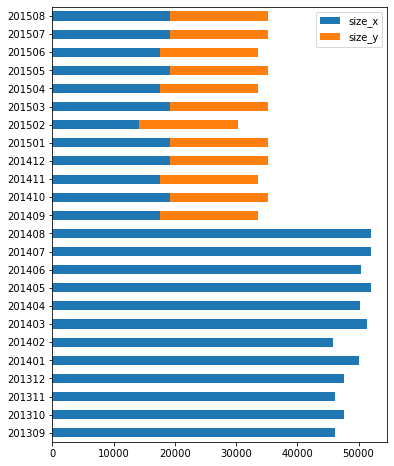

In [26]:
train_groupby, test_groupby = check_yearmonth(train), check_yearmonth(test)
df = pd.merge(train_groupby,test_groupby,on="yearmonth",how="outer")
df.fillna(0)
df.plot.barh(x="yearmonth",align='center',xlabel="", figsize=(6,8), stacked=True)

# 訓練関数

In [27]:
import lightgbm as lgb
cv_score = []
#201409testを予測する場合、201407以前のtrainデータで訓練，201408のtrainデータで検証，
#201410testを予測する場合、201408以前のtrainデータで訓練，201409のtrainデータで検証，
#このように繰り返す
traindata, testdata = train, test
def train(traindata, testdata, year_month):
    if year_month == "201501":
        valid_split = traindata.loc[traindata["yearmonth"] == "201412"]
        train_split = traindata.loc[traindata["yearmonth"] < "201412"]
    else:
        valid_split = traindata.loc[traindata["yearmonth"] == str(int(year_month) - 1)]
        train_split = traindata.loc[traindata["yearmonth"] < str(int(year_month) - 1)]
    test_split = testdata.loc[testdata["yearmonth"] == year_month]
    
    train_split = train_split.drop(["date", "id", "predict"], axis=1)
    valid_split = valid_split.drop(["date", "id", "predict"], axis=1)
    print("train's shape: " + str(train_split.shape))
    print("valid's shape: " + str(valid_split.shape))

    
    # training
    X_train, X_test=train_split.drop(["yearmonth", "bikes_available"], axis=1), valid_split.drop(["yearmonth", "bikes_available"], axis=1)
    Y_train, Y_test=train_split['bikes_available'], valid_split['bikes_available']
    
    lgb_train=lgb.Dataset(X_train,Y_train)
    lgb_eval=lgb.Dataset(X_test,Y_test)
    params={
        'boosting': 'gbdt',
        'objective':'regression',
        'metric':'rmse',
        'learning_rate':0.01,
        'num_leaves': 191,         
        'device': 'gpu',}

    evals_result = {}
    early_stopping_rounds = 100
    model=lgb.train(params, lgb_train, 
                valid_names = ["train", "valid"],
                valid_sets=[lgb_train,lgb_eval],
                evals_result=evals_result, #dict{}でmetricを保存
                verbose_eval=500,  
                num_boost_round=3000, 
                early_stopping_rounds=early_stopping_rounds,
               )
    
    global cv_score
    if early_stopping_rounds == 0:
        cv_score.append(evals_result["valid"]["rmse"][-1])
    else:
        cv_score.append(evals_result["valid"]["rmse"][model.best_iteration - 1])

    
    lgb.plot_metric(evals_result,title='YearMonth' + year_month +'_Metric during training',
      xlabel='Iterations', ylabel='auto', figsize=None, grid=True)
    
    lgb.plot_importance(model, height=0.5,max_num_features=300,title='YearMonth' + year_month +'_Feature Importance',
      xlabel='Feature importance', ylabel="",figsize=(6,8), grid=True)
    
    return test_split, model, cv_score

# 予測関数

In [28]:
def predict(test_split, model_best_iteration):
    #predict
    #test_idで予測結果の順を確保
    test_id = pd.DataFrame(test_split["id"])
    test_id = test_id.reset_index()
    del test_id["index"]

    test_feature = test_split.drop(["id", "predict", "bikes_available", "yearmonth", "date",], axis=1)
    test_label = model.predict(test_feature, num_iteration=model.best_iteration)
    test_label = pd.DataFrame(test_label)

    test_label = pd.concat([test_id, test_label], axis=1)
    return test_label

# 汎用関数

In [29]:
class utils():
    def __init__(self):
        year_month = self.year_month
        cv_score = self.cv_score

    def YearMonth(year_month):
        if year_month == "201501":
            train_year_month, valid_year_month = "201411", "201412"
        elif year_month == "201502":
            train_year_month, valid_year_month = "201412", "201501"
        else:
            train_year_month, valid_year_month = str(int(year_month) - 2), str(int(year_month) - 1)
        test_year_month = year_month
        print("-----------------------------")
        print("Train: 201309 ～ " + train_year_month +" TrainSet" )
        print("Valid: " + valid_year_month + " TrainSet")
        print("Test:  " + test_year_month  + " TestSet")


    def CV(cv_score):
        print("------------ " + " END" + " ------------") 
        cv_score = float(sum(cv_score))/len(cv_score) 
        print ("CV: ", cv_score)  

        
    def get_yearmonth_list():
        _ = []
        for x in range(4):
            year_month = str(201409 + x)
            _.append(year_month)
        for x in range(1,9):
            year_month = str(201500 + x)
            _.append(year_month)
        return _

# 訓練及び予測

-----------------------------
Train: 201309 ～ 201407 TrainSet
Valid: 201408 TrainSet
Test:  201409 TestSet
train's shape: (539515, 42)
valid's shape: (52080, 42)
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 539515, number of used features: 40
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (14.41 MB) transferred to GPU in 0.014469 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 8.601260
Training until validation scores don't improve for 100 rounds
[500]	train's rmse: 2.5966	valid's rmse: 3.17248
Early stopping, best iteration is:
[506]	train's rmse: 2.59437	valid's rmse: 3.17238
 
-----------------------------
Train: 201309 ～ 201408 Train

[500]	train's rmse: 2.74839	valid's rmse: 3.23616
Early stopping, best iteration is:
[448]	train's rmse: 2.77111	valid's rmse: 3.23372
 
-----------------------------
Train: 201309 ～ 201504 TrainSet
Valid: 201505 TrainSet
Test:  201506 TestSet
train's shape: (734955, 42)
valid's shape: (19180, 42)
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1187
[LightGBM] [Info] Number of data points in the train set: 734955, number of used features: 40
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (19.63 MB) transferred to GPU in 0.017946 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 8.520719
Training until validation scores don't improve for 100 rounds
[500]	train's rmse: 2.75872	valid's rmse: 3.45699
Early s

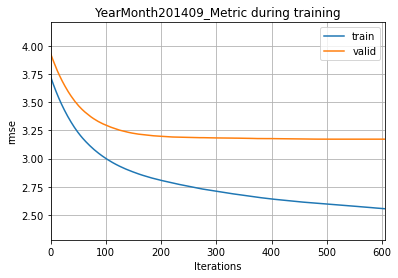

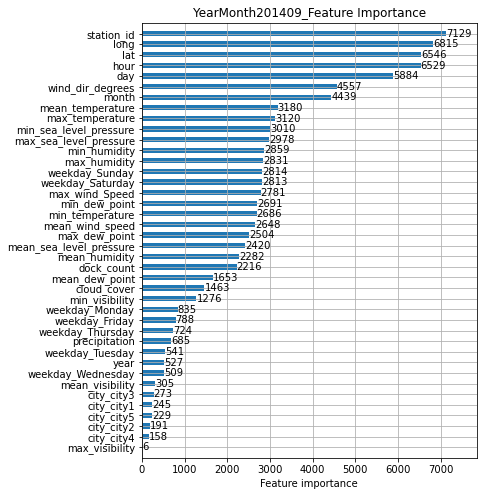

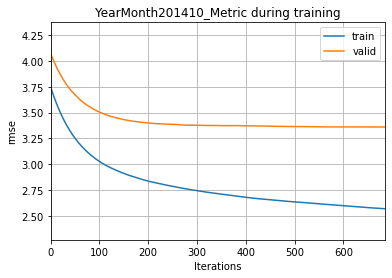

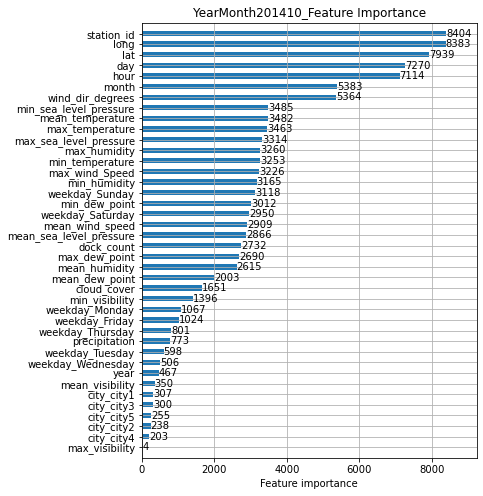

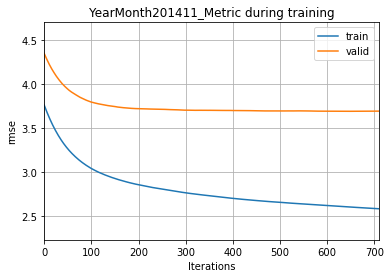

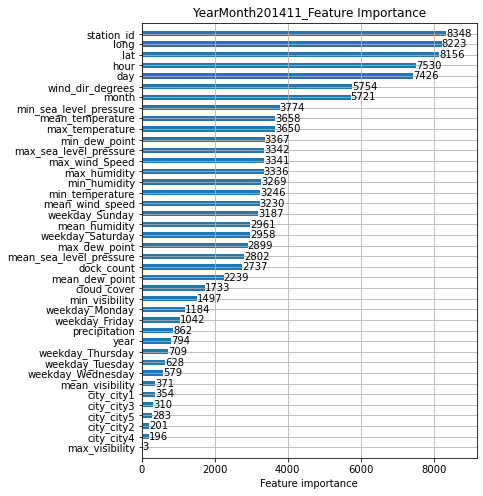

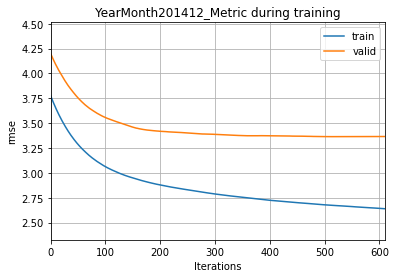

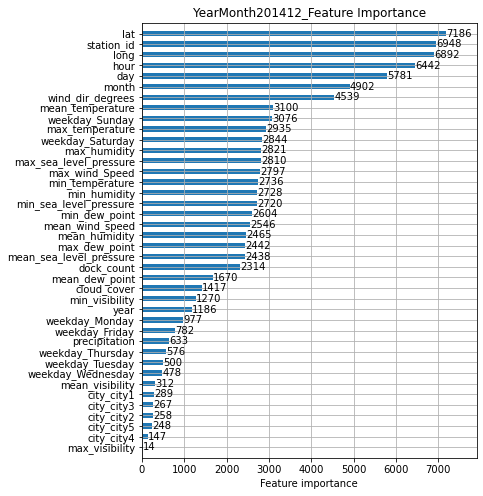

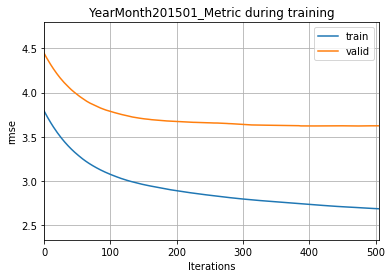

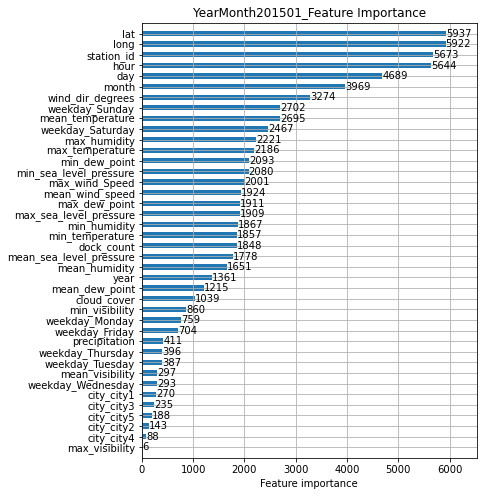

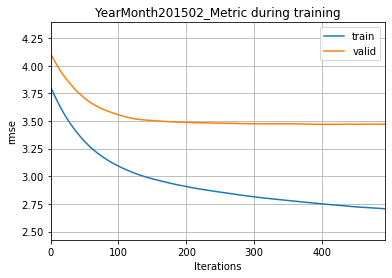

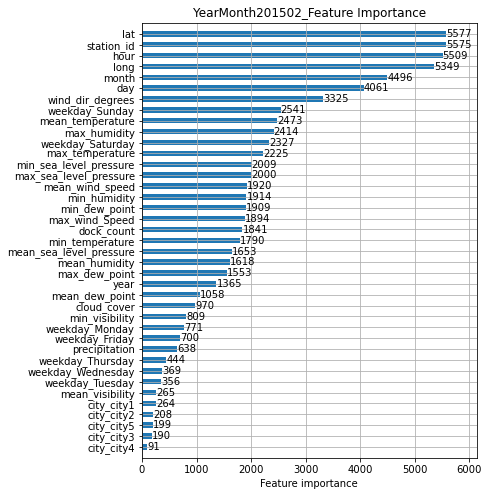

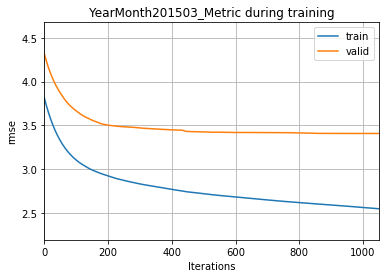

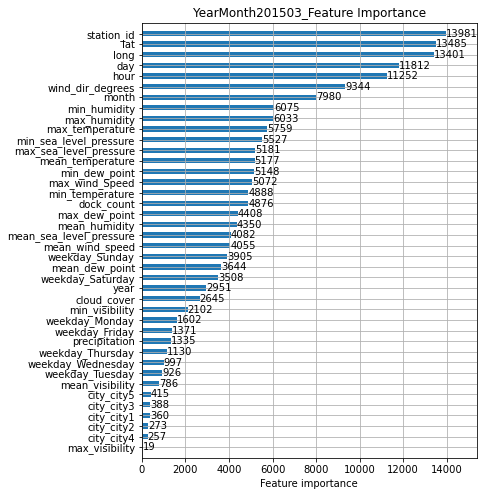

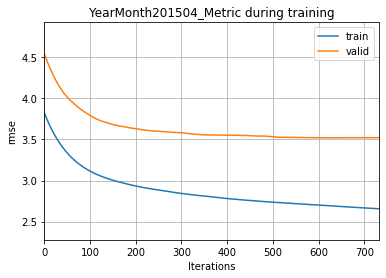

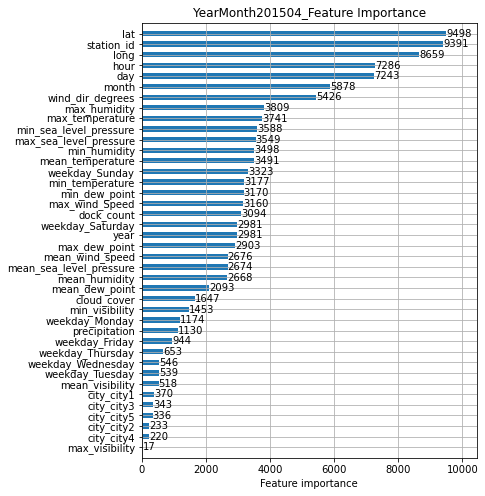

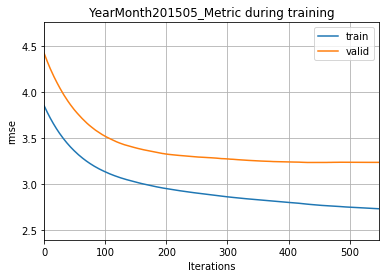

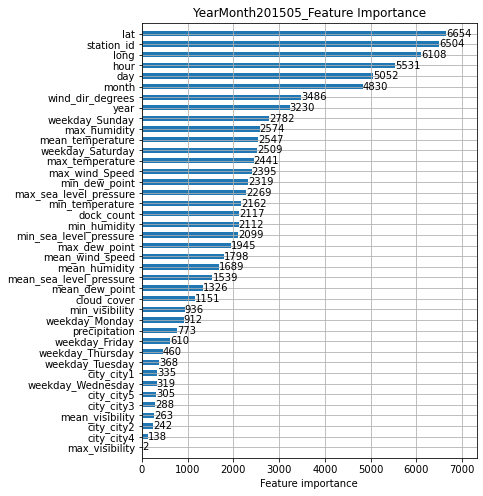

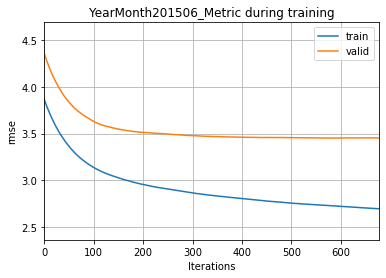

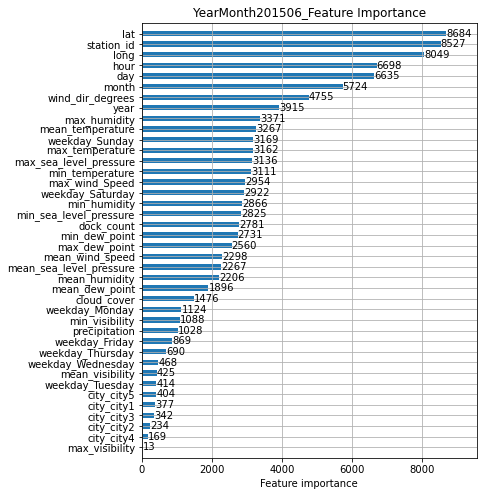

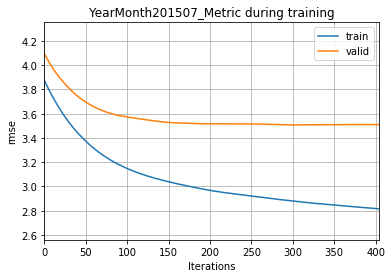

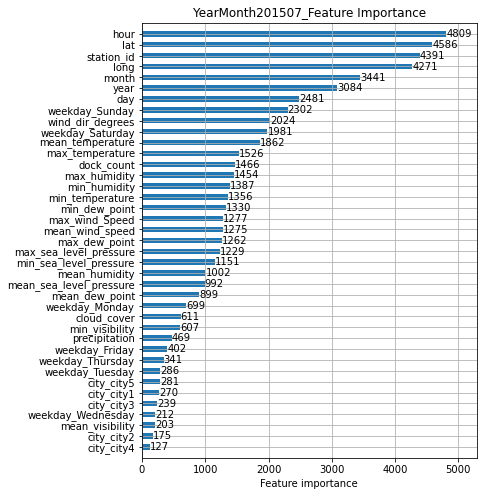

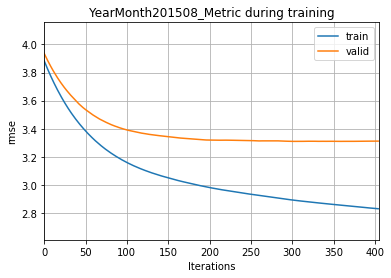

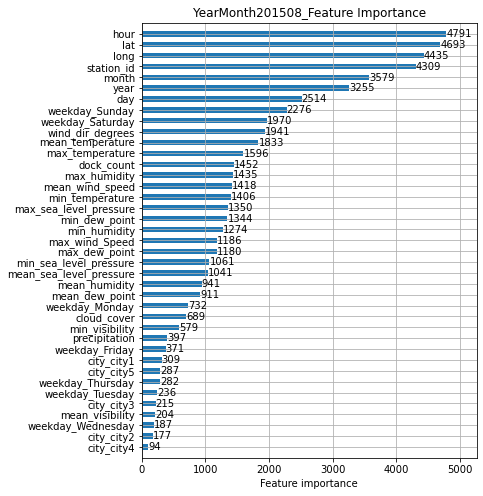

In [30]:
test_labels =[]
test_labels = pd.DataFrame(test_labels)

yearmonth_list = utils.get_yearmonth_list()

while yearmonth_list != []:
    year_month = yearmonth_list.pop(0)
    utils.YearMonth(year_month)
    test_split, model, cv_score = train(traindata, testdata, year_month)
    test_label = predict(test_split, model.best_iteration)
    test_labels = pd.concat([test_labels, test_label])
    print(" ")
    
utils.CV(cv_score)

# 出力

In [31]:
test_labels.columns = ["id", "pred"]
submission = pd.DataFrame(test_labels)
submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193200 entries, 0 to 16099
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      193200 non-null  int64  
 1   pred    193200 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 4.4 MB


In [32]:
submission.to_csv("submission.csv",index=False, header=False)